In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import glob
import time

import powerbox

import numpy as np

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [3]:
def get_rec(rn):
    return np.load(f"{WDIR}/outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()

def get_h5_file_creation_times(pattern):
    file_times = []
    for file in glob.glob(pattern):
        creation_time = os.path.getctime(file)
        file_times.append(creation_time)
    return np.array(file_times)

In [4]:
run_name = 'test_no_inj'
cache_dir = os.environ['P21C_CACHE_DIR'] + '/' + run_name

import py21cmfast as p21c
p21c.config['direc'] = cache_dir

rec = get_rec('test')
brightness_temp = rec['brightness_temp']
lightcone_quantities = ['brightness_temp']

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [ ]:
lightcone = p21c.run_lightcone(
    redshift = brightness_temp.redshift,
    user_params = brightness_temp.user_params,
    cosmo_params = brightness_temp.cosmo_params,
    astro_params = brightness_temp.astro_params,
    flag_options = brightness_temp.flag_options,
    lightcone_quantities = lightcone_quantities,
)

lightcone._write(fname='lc_' + run_name, direc='tmp', clobber=True)

In [6]:
from py21cmfast import plotting

In [ ]:
fig, ax = plt.subplots(figsize = (14, 10))
plotting.lightcone_sliceplot(lightcone, fig=fig, ax=ax) 

In [7]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))    
    
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [8]:
BOX_LEN = 32*2
HII_DIM = 32

k_fundamental = 2*np.pi/BOX_LEN
k_max = k_fundamental * HII_DIM
Nk = np.floor(HII_DIM).astype(int)

In [9]:
out = powerspectra(lightcone, min_k = k_fundamental, max_k = k_max)

/tmp/ipykernel_1083981/2123938222.py:22: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  res = powerbox.tools.get_power(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(


/tmp/ipykernel_1083981/3009079741.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


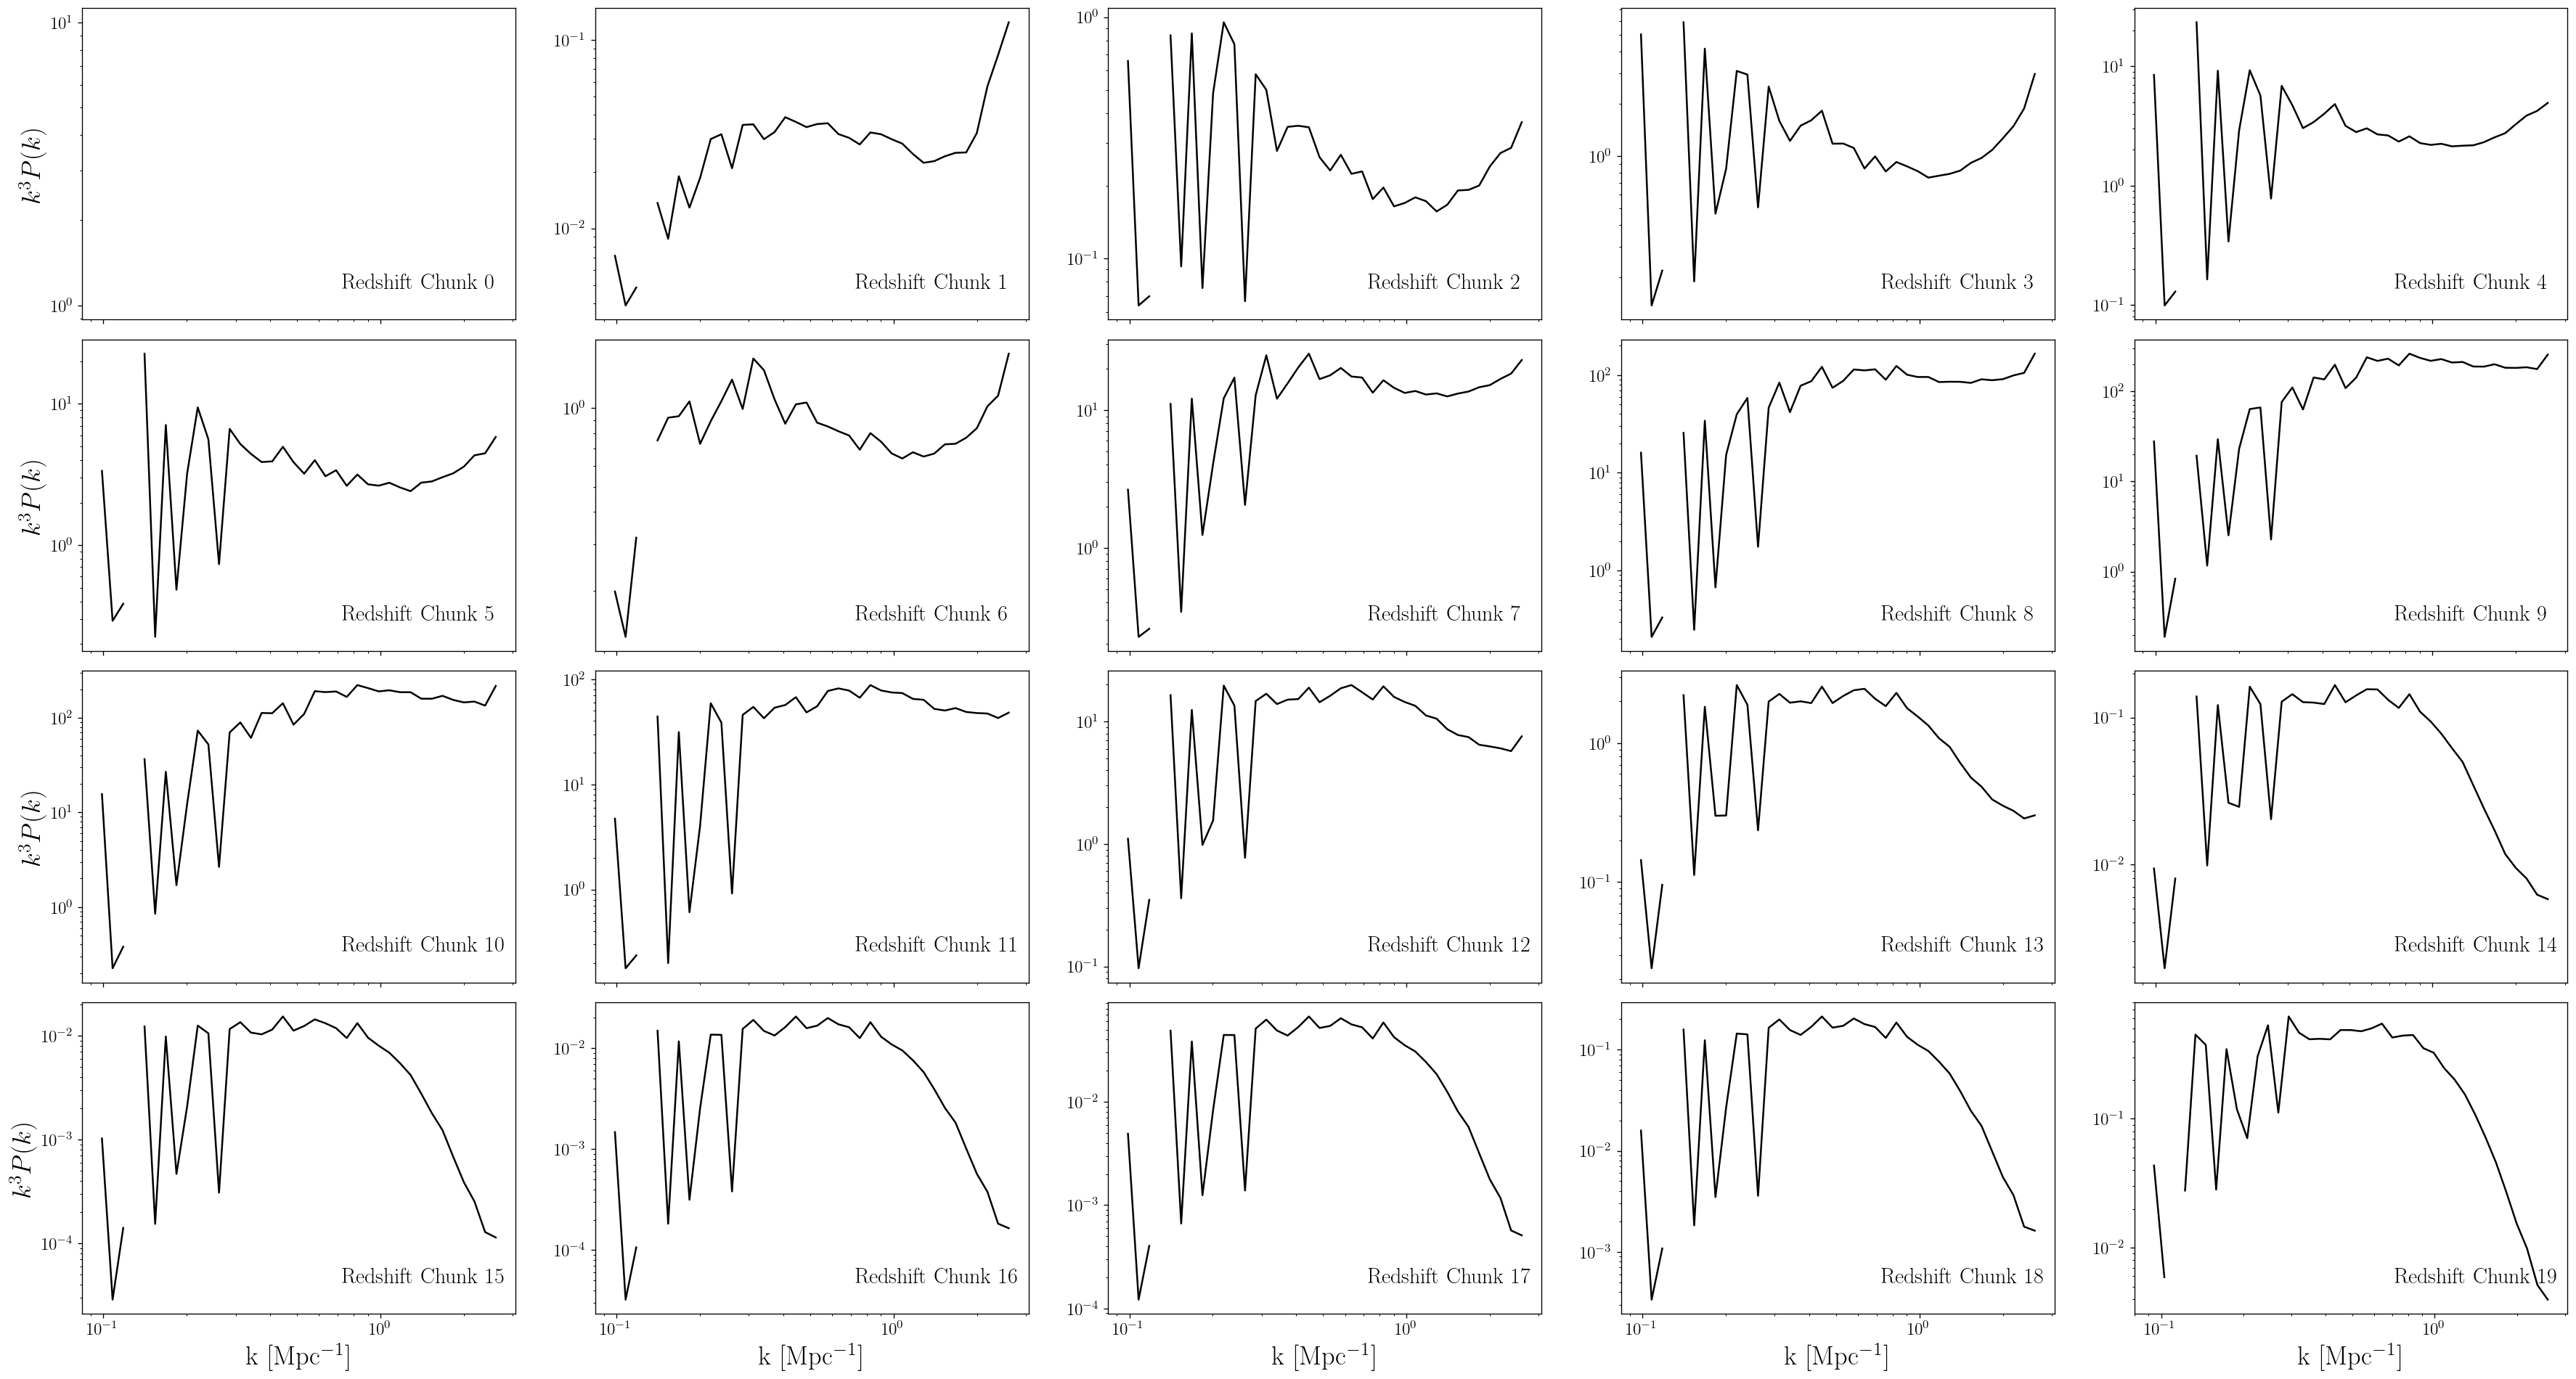

In [10]:
fig, axs = plt.subplots(ncols = 5, nrows = 4, figsize = (30, 16))

for i, item in enumerate(out):
    row_index, col_index = np.unravel_index(i, axs.shape)
    
    ax = axs[row_index, col_index]
    ax.plot(item['k'], item['delta'], color = 'black')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(.6, .1, 'Redshift Chunk ' + str(i), transform=ax.transAxes, fontsize = 18)
    
for i in range(axs.shape[0]-1):
    for j in range(axs.shape[1]):
        axs[i, j].set_xticklabels([])

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$k^3 P(k)$', fontsize = 22)
    
plt.tight_layout()
plt.show()

## h5 creation time

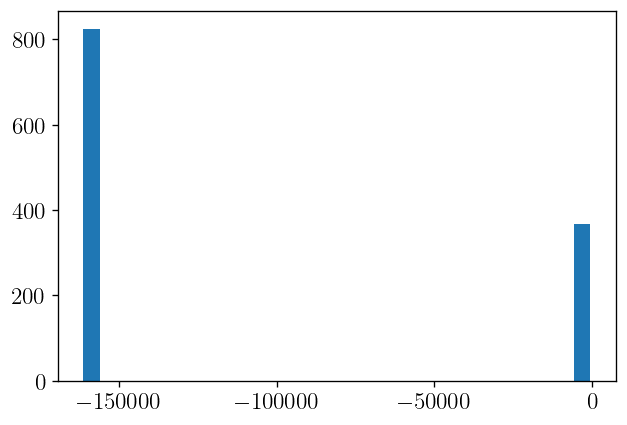

In [11]:
l = get_h5_file_creation_times(f"{cache_dir}/*.h5") - time.time()
plt.hist(l, bins=30);

In [ ]:
lightcone = p21c.run_lightcone(
    redshift = brightness_temp.redshift,
    user_params = brightness_temp.user_params,
    cosmo_params = brightness_temp.cosmo_params,
    astro_params = brightness_temp.astro_params,
    flag_options = brightness_temp.flag_options,
    lightcone_quantities = lightcone_quantities,
)

lightcone._write(fname='lc', direc='tmp', clobber=True)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [4]:
rec.keys()

dict_keys(['z', 'T_s', 'T_b', 'T_k', 'x_e', '1-x_H', 'phot_N', 'dE_inj_per_B', 'dE_inj_per_Bavg_unclustered', 'dep_ion', 'dep_exc', 'dep_heat', 'x_e_slice', 'x_H_slice', 'T_k_slice', 'brightness_temp'])